# A code to quickly check the *trajectory.nc* file content

## Load One (1) data file
Define here the name of the file to check

In [323]:
data_filename = '3_VarLight/2021-12-21/1/trajectory.nc'

In [324]:
from ipywidgets import interact, interactive
import utils.loader

import ipywidgets as widgets

from IPython.display import Markdown, display
from datetime import timedelta
import xarray as xr
import os, sys
import glob
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

root = '/Users/baptistelafoux/Google Drive/Pro/2020_PMMH_thèse_fish/5_PostProcessing/postProCode/python/free_swim_illum_var/'
root_server = '/Volumes/baptiste/data_labox/illuminance_variation/1_raw_data/'

original_video_filename = glob.glob(root_server + os.path.dirname(data_filename) + '/*noBG.mp4')[0]

ds = xr.open_dataset(root + 'cleaned/' + data_filename)
original_video_cap = cv2.VideoCapture(original_video_filename)

print('Video file :', original_video_filename)
print('Data file :', data_filename)

dt = 1 / ds.fps

display(Markdown('**Video**'))
print('Frame rate : {} fps'.format(ds.fps))
print('Video length : {} images ('.format(ds.n_frames) + str(timedelta(seconds=int(ds.n_frames/ds.fps))) + ')')

display(Markdown('**Content**'))
print('Number of individuals : {} fish'.format(ds.n_fish))
print('Average body length : {:.2f} pxl'.format(ds.mean_BL_pxl))

IndexError: list index out of range

### Movie checking

In [5]:
trail_len = 5
delta_t = 100

fig, ax = plt.subplots(1, figsize=(16, 5))

ax = [ax]

def display_movie(t=trail_len):

    ax[0].clear()

    original_video_cap.set(cv2.CAP_PROP_POS_FRAMES, t)
    _, frame = original_video_cap.read()

    ax[0].imshow(frame)
    ax[0].invert_yaxis()
    ax[0].plot(ds.s[t-trail_len:t, :, 0] * ds.mean_BL_pxl,
              ds.s[t-trail_len:t, :, 1] * ds.mean_BL_pxl, linewidth=0.75)
    ax[0].plot(ds.s[t, :, 0] * ds.mean_BL_pxl, ds.s[t, :, 1] * ds.mean_BL_pxl, 'k.')

    #for focal in range(ds.n_fish):
    #   ax[0].annotate(str(focal), (ds.s[t, focal, 0], ds.s[t, focal, 1]), xytext=(2, 5), textcoords='offset points')

    #ax[0].axis('scaled')
    #ax[0].axis([0, ds.tank_size[0], 0, ds.tank_size[1]])

        
slider = interactive(display_movie, t=widgets.IntSlider(min=101, max=ds.n_frames-1, step=1))

display(slider)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=101, description='t', max=21001, min=101), Output()), _dom_classes=('wid…

### Load Alicia's files and check arena detection with Hough Transform

In [34]:
from src.utilities import dataloader
import matplotlib.pyplot as plt
import cv2 
import numpy as np 

%matplotlib widget
file = '/Volumes/baptiste/2019_PMMH_stage_AGimenez_collective/Collective/1_data_alicia/2_cured_datasets/serieB/60dpf/2/Tracking_Result_2/trajectory.nc'
file = '/Volumes/baptiste/2019_PMMH_stage_AGimenez_collective/Collective/1_data_alicia/2_cured_datasets/serieA/videos_adults_boite_190/6/Tracking_Result_6poissons/trajectory.nc'

ds = dataloader(file)


bg = plt.imread(ds.bg_filename)
circles = cv2.HoughCircles(bg, cv2.HOUGH_GRADIENT, 1, bg.shape[0] / 8,
                          param1=100, param2=30,
                          minRadius=100, maxRadius=1000)
plt.figure()
plt.imshow(bg, cmap='Greys_r')

circles = circles[0, 0, :]
c = plt.Circle(circles[0:2], circles[-1])
plt.gca().add_patch(c) 


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Load one file and check peak detection for B&C detection 

In [14]:
from utils.loader import dataloader
import matplotlib.pyplot as plt
import cv2 
import numpy as np 
from scipy.signal import savgol_filter, find_peaks

%matplotlib widget
data_filename = 'cleaned/3_VarLight/2021-12-21/1/trajectory.nc'

ds = dataloader(data_filename)
t = 40 * 60
i = 10

fig, ax = plt.subplots() 
theta = np.arctan2(ds.e[:,i,0], ds.e[:,i,1])
data = np.unwrap(theta)

ax.plot(ds.time, data %(2*np.pi))
i_peaks = find_peaks(np.abs(np.gradient(data)))[0]
ax.plot(ds.time[i_peaks], (data % (2*np.pi))[i_peaks], 'ro')
ax.set_xlim([t, t+100])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(2400.0, 2500.0)

### Plot all experiment result together 

In [329]:
import matplotlib.pyplot as plt
from src.analysis import add_var_vs_light
import numpy as np 
%matplotlib widget

from utils.data_operations import add_modified_rot_param

from utils.loader import dataloader_multiple
import glob 
paths = glob.glob('cleaned/*/**/2022*/*/', recursive=True) + \
    glob.glob('cleaned/*/**/2021-12-21*/*/', recursive=True)

ds = dataloader_multiple(paths)

def add_var_vs_time(ds, var, ax, downsmpl_per=180, add_illu=False, **kwargs):

    if add_illu:
        add_illuminance_on_plot(ax, ds, scaling_factor=add_illu)
        ax.legend()

    win_size = int(downsmpl_per * ds.fps)
    ds_avg = ds.coarsen(time=win_size, boundary='trim').mean()

    ax.plot(ds.time, ds[var], 'k.', markersize=0.1)
    ax.plot(ds_avg.time, ds_avg[var], **kwargs)

    ax.set_xlabel('Time [s]')

fig, ax = plt.subplots() 
fig, ax0 = plt.subplots()
for exp in ds.experiment:
    DS = np.abs(ds.sel(experiment=exp))
    add_var_vs_light(np.abs(DS), 'rot_param', ax0, correc=True, all_values=False, linestyle='-', marker=None)
    add_var_vs_time(DS, 'rot_param', ax)


ImportError: cannot import name 'add_modified_rot_param' from 'utils.data_operations' (/Users/baptistelafoux/Google Drive/Pro/2020_PMMH_thèse_fish/5_PostProcessing/postProCode/python/free_swim_illum_var/utils/data_operations.py)

### Test on binned 2D map statistics

In [112]:
from utils.loader import dataloader
import matplotlib.pyplot as plt
import cv2 
import numpy as np 
from scipy.signal import savgol_filter, find_peaks
import trajectorytools as tt 
from scipy import stats
from progressbar import progressbar

%matplotlib widget
data_filename = 'cleaned/3_VarLight/2021-12-21/1/trajectory.nc'

ds = dataloader(data_filename)

theta_resp = np.zeros((ds.n_frames, ds.n_fish, ds.n_fish))
sr = np.zeros((ds.n_frames, ds.n_fish, ds.n_fish, 2))

e_rot = np.zeros_like(sr)

for focal in progressbar(range(ds.n_fish)): 
    theta_resp[:, focal, :] = ds.theta[:, focal].to_numpy()[..., np.newaxis] - ds.theta
    sc_focal = ds.s.to_numpy() - ds.s.to_numpy()[:, focal, np.newaxis, :] 
    e_rot[:,focal, ...] = tt.fixed_to_comoving(ds.e, ds.e[:,focal,:].to_numpy() ) 
    sr[:,focal, ...] = tt.fixed_to_comoving(sc_focal, ds.e[:,focal,:].to_numpy() )

x = sr[...,0].flatten()
y = sr[...,1].flatten()

lim = 12
idx = (np.abs(x) < lim) & (np.abs(y) < lim)

nBins = 35
#theta_map, x_edge, y_edge, nb = stats.binned_statistic_2d(y[idx], x[idx], theta_resp.flatten()[idx], statistic = np.nanmean, bins = nBins)

###########

from utils.graphic import center_bins
from scipy import ndimage

t = 10000 

nBins = 65
e_x, x_edge, y_edge, nb = stats.binned_statistic_2d(sr[...,1].flatten(), sr[...,0].flatten(), e_rot[...,0].flatten(), statistic = np.nanmean, bins = nBins)
e_y, x_edge, y_edge, nb = stats.binned_statistic_2d(sr[...,1].flatten(), sr[...,0].flatten(), e_rot[...,1].flatten(), statistic = np.nanmean, bins = nBins)

x_c, y_c = center_bins(x_edge, x_edge)
fig, ax = plt.subplots() 
#cnt = ax.contourf(x_c, y_c, ndimage.gaussian_filter(theta_map, 0.6), cmap='twilight')
ax.streamplot(x_c, y_c, e_x, e_y, color='k', linewidth=0.85, integration_direction='forward', arrowsize=0.8, density=2)

ax.axis('scaled')
ax.axis([-20, 20, -20, 20])
#fig.colorbar(cnt) 

###########

x_c, y_c = center_bins(x_edge, x_edge)
fig, ax = plt.subplots() 
#cnt = ax.contourf(x_c, y_c, ndimage.gaussian_filter(theta_map, 0.6), cmap='twilight')
#ax.streamplot(y_c, x_c, e_x, e_y, color='k', linewidth=0.85, integration_direction='forward', arrowsize=0.8, density=4)
ax.quiver(y_c, x_c, e_x, e_y, color='k')
ax.axis([-20, 20, -20, 20])
#fig.colorbar(cnt) 


100% (58 of 58) |########################| Elapsed Time: 0:00:14 Time:  0:00:14


### Check different expression for the miling parameter

In [322]:
from utils.loader import dataloader
from utils.data_operations import xarray_vector_norm
import matplotlib.pyplot as plt
import cv2 
import numpy as np 
from scipy.signal import savgol_filter, find_peaks
import trajectorytools as tt 
from scipy import stats
from progressbar import progressbar

import matplotlib.pyplot as plt 
plt.rcParams['text.usetex'] = True

%matplotlib widget
data_filename = 'cleaned/3_VarLight/2022-01-06/1/trajectory.nc'

ds = dataloader(data_filename)

fig, ax = plt.subplots()

ds['s'], ds['center_of_mass'] = xr.broadcast(ds.s, ds.center_of_mass)
ds['r'] = ds.s - ds.center_of_mass

ds['e_r'] = ds.r / xarray_vector_norm(ds.r, dim='space')

L = ds.ii_dist.mean(dim=['neighbour', 'fish']).min()
L = xarray_vector_norm(ds.r, dim='space').mean('fish').min()

ii_dist_avg = ds.ii_dist.mean(dim=['neighbour', 'fish'])
ds['C'] = 1 - (ii_dist_avg - np.min(ii_dist_avg)) / np.max(ii_dist_avg)

r_norm = xarray_vector_norm(ds.r, dim='space')
L = 6
ds['comp_rot_param'] = (np.cross(ds.r.where(r_norm < L), ds.v.where(r_norm < L)) / (xarray_vector_norm(ds.r.where(r_norm < L), dim='space') * (xarray_vector_norm(ds.v.where(r_norm < L), dim='space') + 10**(-9)) )).mean(dim='fish')
print(ds.comp_rot_param.shape)
ds = ds.coarsen(time=120, boundary='trim').mean()



ax.plot(ds.time, np.abs(ds.rot_param), label=r'$\mathcal M$')
ax.plot(ds.time, np.abs(ds.rot_param * ds.C), label=r'$\mathcal M (1 - \frac{\bar d - \min d}{\max d})$')
ax.plot(ds.time, np.abs(ds.comp_rot_param), 'o', label=r'Modif of $\mathcal M$')

ax.legend()
ax.set_ylim([0, 1])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(19502,)


(0.0, 1.0)

### Distributions of NND 

In [255]:
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib widget

from utils.loader import dataloader_multiple

from utils.data_operations import group_dataset

import glob 
paths = glob.glob('cleaned/*/**/2022*/*/', recursive=True) + \
    glob.glob('cleaned/*/**/2021-12-21*/*/', recursive=True)

ds = dataloader_multiple(paths)

ds_avg, ds_std = group_dataset(ds, 'light', n_bins=10)



################ Creating a large dataset to gather multiple experiments ################

///// WARNING : here we average all variables over 1 s \\\\ 

Merging file : cleaned/3_VarLight/cleaned/3_VarLight/2022-01-04/1//trajectory.nc - 1/6

##### Computing focal values
Basis translation and rotation
#### Done computing focal values in {t2- t1:.2f} s. They are added as new variables in the dataset

Merging file : cleaned/3_VarLight/cleaned/3_VarLight/2022-01-04/2//trajectory.nc - 2/6

##### Computing focal values
Basis translation and rotation
#### Done computing focal values in {t2- t1:.2f} s. They are added as new variables in the dataset

Merging file : cleaned/3_VarLight/cleaned/3_VarLight/2022-01-06/1//trajectory.nc - 3/6

##### Computing focal values
Basis translation and rotation
#### Done computing focal values in {t2- t1:.2f} s. They are added as new variables in the dataset

Merging file : cleaned/3_VarLight/cleaned/3_VarLight/2022-01-06/2//trajectory.nc - 4/6

##### Computing

In [254]:
from utils.graphic import center_bins
import cmocean
import palettable
import matplotlib
t_cm = palettable.tableau.Tableau_10.mpl_colors

cm1 = matplotlib.colors.rgb_to_hsv(t_cm[1])
cm1 = matplotlib.colors.ListedColormap([matplotlib.colors.hsv_to_rgb([cm1[0], cm1[1], i]) for i in np.linspace(0.4, 1, 10)])

cm2 = matplotlib.colors.rgb_to_hsv(t_cm[2])
cm2 = matplotlib.colors.ListedColormap([matplotlib.colors.hsv_to_rgb([cm2[0], cm2[1], i]) for i in np.linspace(0.4, 1, 10)])

from scipy.stats.kde import gaussian_kde
plt.rcParams['text.usetex'] = False
nbins = 10
cmap = cmocean.cm.thermal
fig, ax  = plt.subplots()
fig, ax2 = plt.subplots()

bins = np.logspace(-2, 0, nbins)
#bins = np.linspace(0, 1, nbins)

NNDmax = 5
x = np.linspace(0, NNDmax, 100)
x2 = np.linspace(0, 35, 150)

for i, (l_l, l_r) in enumerate(zip(bins[:-1], bins[1:])):
    
    ds_temp = ds.where((ds.light>l_l) & (ds.light<l_r))

    nn_dist = ds_temp.nn_dist.to_numpy().flatten()
    nn_dist = nn_dist[~np.isnan(nn_dist) & (nn_dist < NNDmax)]
    hist, bins = np.histogram(nn_dist, bins=400, density=True) 
    bins = bins[:-1] + np.diff(bins) / 2

    ax.plot(bins, hist, '.', ms=1, color=cm1(i/nbins))
    kde = gaussian_kde(nn_dist)

    ax.plot(x, kde(x), '-', color=cm1(i/nbins), label=rf'$\bar E$ $\in$ [{l_l:.2f} - {l_r:.2f}]')

    ii_dist = ds_temp.ii_dist.mean('neighbour').to_numpy().flatten()
    ii_dist = ii_dist[~np.isnan(ii_dist)]

    hist, bins = np.histogram(ii_dist, bins=250, density=True) 
    bins = bins[:-1] + np.diff(bins) / 2

    ax2.plot(bins, hist, '.', ms=1, color=cm2(i/nbins))
    kde = gaussian_kde(ii_dist)

    ax2.plot(x2, kde(x2), '-', color=cm2(i/nbins), label=rf'$\bar E$ $\in$ [{l_l:.2f} - {l_r:.2f}]')

ax.set_title('Gaussian Kernel Density Estimator for PDF of the NND')    
ax.set_ylabel('PDF [-]')
ax.set_xlabel('NN-D [BL]')
ax2.set_title('Gaussian Kernel Density Estimator for PDF of the IID')    
ax2.set_ylabel('PDF [-]')
ax2.set_xlabel('II-D [BL]')
ax.legend()
ax2.legend()
fig, ax = plt.subplots() 
ax.plot(ds.light.T, ds.nn_dist.mean(dim='fish').T, '.')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Plot the x and y distances

Ici je trace des cartes de densité de présence des NN (ième NN jusqu'au jème NN), en fonction de différents niveaux de lumière (attention ces niveau de lumière sont répartis en logspace)

0/5 - [0.01 - 0.03] - Number of points : 44400
1/5 - [0.03 - 0.06] - Number of points : 125803
2/5 - [0.06 - 0.16] - Number of points : 393142
3/5 - [0.16 - 0.40] - Number of points : 1060386
4/5 - [0.40 - 1.00] - Number of points : 3269384


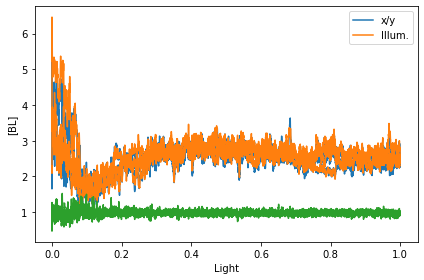

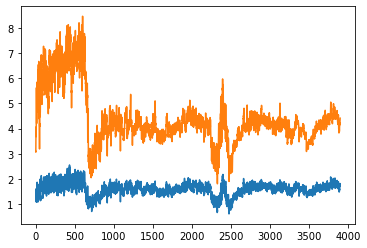

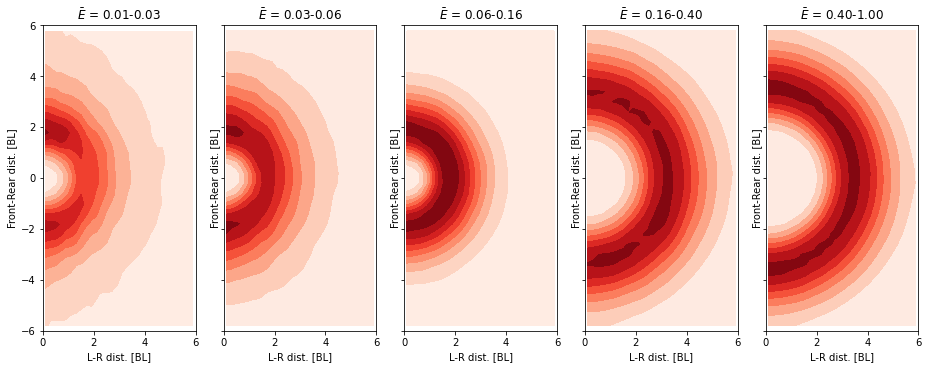

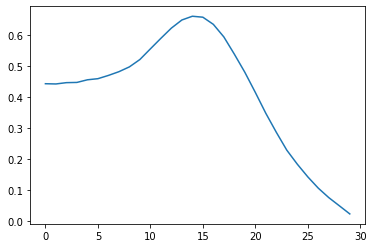

In [408]:
from utils.loader import dataloader
from utils.data_operations import xarray_vector_norm
import matplotlib.pyplot as plt
import cv2 
import numpy as np 
from scipy.signal import savgol_filter, find_peaks
import trajectorytools as tt 
from scipy import stats
from progressbar import progressbar
import xarray as xr
from utils.data_operations import index_nn
from utils.graphic import add_illuminance_on_plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

from scipy.ndimage import gaussian_filter
matplotlib.get_backend()
%matplotlib inline

data_filename = 'cleaned/3_VarLight/2022-01-06/1/trajectory.nc'

ds = dataloader(data_filename)
#ds = ds.coarsen(time=3, boundary='trim').mean()


s_centered = ds.s.to_numpy()[:, None, ...] - ds.s.to_numpy()[:, :, None, ...]
s_centered_on_centroid = ds.s - ds.center_of_mass
sr = tt.fixed_to_comoving(s_centered, ds.e.to_numpy()[..., None, :])

i_nn = index_nn(ds, N=10, include_self=False)
dist_nn = np.take_along_axis(sr, i_nn.to_numpy()[..., None], axis=2)


#####
dist_nn = dist_nn[..., 3:-1, :]
######

fig, ax = plt.subplots()
fig.set_tight_layout(True)
#ax.plot(ds.time, ds.nn_dist.mean(dim='fish'), 'k--')
ax.plot(ds.light, np.abs(dist_nn).mean(axis=(1, 2)))
m_nnd = np.abs(dist_nn).mean(axis=(1, 2))
ax.plot(ds.light, m_nnd[..., 0] / m_nnd[..., 1])
#add_illuminance_on_plot(ax, ds)

ax.legend(['x/y', 'Illum.'])
ax.set_ylabel('[BL]')
ax.set_xlabel('Light')
fig, ax = plt.subplots() 

ax.plot(ds.time, ds.nn_dist.mean(dim='fish'))
ax.plot(ds.time, np.linalg.norm(dist_nn, axis=-1).mean(axis=(-1, -2)))

nbins = 6

fig, axs = plt.subplots(1, nbins-1, figsize=(13, 5), sharey=True)
#fig.set_tight_layout(True)
bins = np.logspace(-2, 0, nbins)
#bins = np.linspace(0, 1, nbins)

fmt = lambda x, pos: '{:.0E}'.format(x)

im = [0] * (nbins - 1)

lim = 6

for i, (l_l, l_r) in enumerate(zip(bins[:-1], bins[1:])):

    x, y = dist_nn[(ds.light > l_l) & (ds.light < l_r)].reshape((-1, 2)).T

    #x, y = s_centered[(ds.light > l_l) & (ds.light < l_r)].reshape((-1, 2)).T

    idx = ~np.isnan(x) & ~np.isnan(y) & (np.sqrt(x**2 + y**2) < lim)
    x = x[idx]; y = y[idx]

    print(f'{i}/{nbins-1} - [{l_l:.2f} - {l_r:.2f}] - Number of points : {len(x)}')
    map, y_edges, x_edges = np.histogram2d(y, np.abs(x), bins=30, density=True)

    x_center, y_center = center_bins(x_edges, y_edges)

    im[i] = axs[i].contourf(x_center, y_center, gaussian_filter(map, 0.8), levels=8, cmap='Reds')

    axs[i].set_title(rf'$\bar E$ = {l_l:.2f}-{l_r:.2f}')
    axs[i].set_xlabel('L-R dist. [BL]')
    axs[i].set_ylabel('Front-Rear dist. [BL]')

#    axs[i, 1].plot(map.sum(axis=1), y_center, 'k')
#    axs[i, 1].set_xlim(0, 1)

    axs[i].axis('scaled')
    axs[i].axis([0, lim, -lim, lim])

fig.tight_layout()

fig, ax = plt.subplots()
ax.plot(map.sum(axis=0))


In [446]:
from utils.loader import dataloader
from utils.data_operations import xarray_vector_norm
import matplotlib.pyplot as plt
import cv2 
import numpy as np 
from scipy.signal import savgol_filter, find_peaks
import trajectorytools as tt 
from scipy import stats
from progressbar import progressbar
import xarray as xr
from utils.data_operations import index_nn
from utils.graphic import add_illuminance_on_plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

from scipy.ndimage import gaussian_filter
matplotlib.get_backend()
%matplotlib widget

data_filename = 'cleaned/3_VarLight/2022-01-06/1/trajectory.nc'

ds = dataloader(data_filename)
#ds = ds.coarsen(time=3, boundary='trim').mean()

s_centered_on_centroid = ds.s - ds.center_of_mass

nbins = 9

fig, axs = plt.subplots(1, nbins-1, figsize=(25, 5), sharey=True)
fig.set_tight_layout(True)
bins = np.logspace(-1.5, 0, nbins)
#bins = np.linspace(0, 1, nbins)


for i, (l_l, l_r) in enumerate(zip(bins[:-1], bins[1:])):

    x, y = s_centered_on_centroid[(ds.light > l_l) & (ds.light < l_r)].to_numpy().reshape((-1, 2)).T

    idx = ~np.isnan(x) & ~np.isnan(y) 
    x = x[idx]; y = y[idx]

    print(f'{i}/{nbins-1} - [{l_l:.2f} - {l_r:.2f}] - Number of points : {len(x)}')
    map, y_edges, x_edges = np.histogram2d(y, x, bins=40, density=True)

    x_center, y_center = center_bins(x_edges, y_edges)

    axs[i].pcolormesh(x_center, y_center, gaussian_filter(map, 0.9), cmap='Reds', shading='auto')

    axs[i].set_title(rf'$\bar E$ = {l_l:.2f}-{l_r:.2f}')

    axs[i].axis('scaled')
    axs[i].axis(np.c_[-ds.tank_size/2, ds.tank_size/2].flatten())



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0/8 - [0.03 - 0.05] - Number of points : 12243
1/8 - [0.05 - 0.07] - Number of points : 18815
2/8 - [0.07 - 0.12] - Number of points : 28991
3/8 - [0.12 - 0.18] - Number of points : 44573
4/8 - [0.18 - 0.27] - Number of points : 68688
5/8 - [0.27 - 0.42] - Number of points : 126935
6/8 - [0.42 - 0.65] - Number of points : 217194
7/8 - [0.65 - 1.00] - Number of points : 334536


In [422]:
np.c_[-ds.tank_size/2, ds.tank_size/2].flatten()

array([-20.2266199 ,  20.2266199 , -14.18330054,  14.18330054])

In [1]:
from utils.loader import dataloader_multiple

import glob 
paths = glob.glob('cleaned/*/**/2022*/*/', recursive=True) + \
    glob.glob('cleaned/*/**/2021-12-21*/*/', recursive=True)

ds = dataloader_multiple(paths)

ds = ds.coarsen(time=10, boundary='trim').mean()

nbins = 6

ds_avg, ds_std = group_dataset(ds, 'light', n_bins=nbins)

################ Creating a large dataset to gather multiple experiments ################

///// WARNING : here we average all variables over 1 s \\\\ 

Merging file : cleaned/3_VarLight/cleaned/3_VarLight/2022-01-04/1//trajectory.nc - 1/6
Merging file : cleaned/3_VarLight/cleaned/3_VarLight/2022-01-04/2//trajectory.nc - 2/6
Merging file : cleaned/3_VarLight/cleaned/3_VarLight/2022-01-06/1//trajectory.nc - 3/6
Merging file : cleaned/3_VarLight/cleaned/3_VarLight/2022-01-06/2//trajectory.nc - 4/6
Merging file : cleaned/3_VarLight/cleaned/3_VarLight/2021-12-21/1//trajectory.nc - 5/6
Merging file : cleaned/3_VarLight/cleaned/3_VarLight/2021-12-21/2//trajectory.nc - 6/6

Merging all 6 datasets took 10.54 s


NameError: name 'group_dataset' is not defined

In [337]:
from utils.data_operations import group_dataset, xarray_vector_norm
from utils.graphic import center_bins

import matplotlib.pyplot as plt
import numpy as np 

%matplotlib widget


fig, axs = plt.subplots(1, nbins-1, figsize=(20, 4))

light_bins = np.logspace(-2, 0, nbins)
light_bins = np.linspace(0, 1, nbins)

for i, (l_l, l_r) in enumerate(zip(light_bins[:-1], light_bins[1:])):

    ds_temp = ds.where((ds.light>l_l) & (ds.light<l_r) & (xarray_vector_norm(ds.sr)<4))# & (xarray_vector_norm(ds.sr)>0.1))

    x, y = ds_temp.sr.sel(neighbour=2).to_numpy().reshape((-1, 2)).T
    idx = ~np.isnan(x) & ~np.isnan(y)
    x = x[idx]; y = y[idx]

    print(f'{i}/{nbins-1} - [{l_l:.2f} - {l_r:.2f}] - Number of points : {len(x)}')
    map, x_edges, y_edges = np.histogram2d(x, y, bins=35)

    x_center, y_center = center_bins(x_edges, y_edges)

    axs[i].contourf(x_center, y_center, map, cmap='Reds')
    axs[i].axis('scaled')
    axs[i].set_title(rf'{l_l:.2f} - {l_r:.2f}')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: 'Dataset' object has no attribute 'sr'

In [338]:
fig, ax = plt.subplots() 

#ds = np.abs(ds).mean(dim='experiment')

#data = np.abs(ds.sr.sel(fish=40)).mean(dim=['neighbour','experiment'])

#ax.plot(ds.sel(experiment=0).time, data) 

ax.plot(ds.light, ds.nn_dist.mean(dim=['fish']), '.')

ax.plot(ds.light, ds.ii_dist.mean(dim=['neighbour', 'fish']), '.')

ax.plot(ds.light, ds.sr.mean(dim=['neighbour', 'fish']), '.')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: 'Dataset' object has no attribute 'sr'

[0. 0. 0. 0. 0. 1.]


In [178]:
m_nnd.shape

(2100, 2)

In [115]:
idx_sorted.shape 

(21002, 58)

In [156]:
dist_nn.shape

(21002, 58, 1, 2)

In [179]:
dist_nn.shape

(2100, 49, 7, 2)

In [187]:
dist_nn = xr.DataArray(data=dist_nn, dims=['time', 'fish', 'neighbour', 'space'])

ds.assign(dist_nn=dist_nn) 

In [212]:
ds.theta.to_numpy()[:, None, ...] -  ds.theta.to_numpy()[:, :, None, ...]

array([[[ 0.        , -0.768013  , -1.20409625, ..., -2.320832  ,
         -2.018622  , -1.094202  ],
        [ 0.768013  ,  0.        , -0.43608325, ..., -1.552819  ,
         -1.250609  , -0.326189  ],
        [ 1.20409625,  0.43608325,  0.        , ..., -1.11673575,
         -0.81452575,  0.10989425],
        ...,
        [ 2.320832  ,  1.552819  ,  1.11673575, ...,  0.        ,
          0.30221   ,  1.22663   ],
        [ 2.018622  ,  1.250609  ,  0.81452575, ..., -0.30221   ,
          0.        ,  0.92442   ],
        [ 1.094202  ,  0.326189  , -0.10989425, ..., -1.22663   ,
         -0.92442   ,  0.        ]],

       [[ 0.        ,  0.130655  , -2.83910773, ..., -1.626577  ,
         -1.324367  , -0.399947  ],
        [-0.130655  ,  0.        , -2.96976273, ..., -1.757232  ,
         -1.455022  , -0.530602  ],
        [ 2.83910773,  2.96976273,  0.        , ...,  1.21253073,
          1.51474073,  2.43916073],
        ...,
        [ 1.626577  ,  1.757232  , -1.21253073, ...,  

In [448]:
d = dict(a = 12, c=13)

d

{'a': 12, 'c': 13}

In [197]:
np.repeat(ds.theta.to_numpy()[..., None, :], repeats=ds.n_fish, axis=1).shape

(2100, 49, 49)

In [219]:
e_r[0, 0, 1, :]

array([0.55070985, 0.48010561])

In [224]:
ds.e[0, 0:2]

<xarray.DataArray 'e' (fish: 2, space: 2)>
array([[-0.72734508, -0.56517594],
       [-0.71701111,  0.14027761]])
Coordinates:
    time     float64 0.9
  * fish     (fish) int64 0 1
  * space    (space) object 'x' 'y'

In [242]:
ds.v[0, 0:2]  / np.linalg.norm(ds.v[0, 0:2], axis=-1)

<xarray.DataArray 'v' (fish: 2, space: 2)>
array([[-0.99542389,  0.13649968],
       [-0.70004017,  0.00717764]])
Coordinates:
    time     float64 0.9
  * fish     (fish) int64 0 1
  * space    (space) object 'x' 'y'

In [256]:

ds.v[0:3, 0:2, ...] / np.linalg.norm(ds.v[0:3, 0:2,...], axis=-1)[..., None]

<xarray.DataArray 'v' (time: 3, fish: 2, space: 2)>
array([[[-0.99542389,  0.09555772],
        [-0.99997424,  0.00717764]],

       [[-0.99867026, -0.05155297],
        [-0.99955386, -0.0298678 ]],

       [[-0.99709344,  0.07618837],
        [-0.56422127, -0.82562362]]])
Coordinates:
  * time     (time) float64 0.9 2.9 4.9
  * fish     (fish) int64 0 1
  * space    (space) object 'x' 'y'

In [252]:
np.linalg.norm(ds.v[0:3, 0:2, ...], axis=-1)

array([[0.85022154, 0.59520456],
       [0.89583623, 1.33982415],
       [0.08238192, 0.09536755]])

In [265]:
ds.e[0, 0:2, ...]
np.cos(ds.theta[0, 0:2]), np.sin(ds.theta[0, 0:2])

(<xarray.DataArray 'theta' (fish: 2)>
 array([-0.78620087, -0.9948174 ])
 Coordinates:
     time     float64 0.9
   * fish     (fish) int64 0 1,
 <xarray.DataArray 'theta' (fish: 2)>
 array([-0.61797103,  0.10167764])
 Coordinates:
     time     float64 0.9
   * fish     (fish) int64 0 1)

In [264]:
ds.e[0, 0:2, ...]

<xarray.DataArray 'e' (fish: 2, space: 2)>
array([[-0.72734508, -0.56517594],
       [-0.71701111,  0.14027761]])
Coordinates:
    time     float64 0.9
  * fish     (fish) int64 0 1
  * space    (space) object 'x' 'y'

In [266]:
ds.vel[0, 0]

<xarray.DataArray 'vel' ()>
array(1.3442203)
Coordinates:
    time     float64 0.9
    fish     int64 0

In [268]:
np.sqrt(ds.v[0, 0, 0] ** 2 + ds.v[0, 0, 1] ** 2)

<xarray.DataArray 'v' ()>
array(0.85022154)
Coordinates:
    time     float64 0.9
    fish     int64 0

In [269]:
np.linalg.norm(ds.v[0, 0])

0.8502215442880626

In [1]:

data_filename = 'cleaned/3_VarLight/2022-01-06/2/trajectory.nc'

ds = dataloader(data_filename)
#ds = ds.coarsen(time=10, boundary='trim').mean()

e_r = tt.fixed_to_comoving(ds.e.to_numpy()[:, None, ...], ds.e.to_numpy()[:, :, None, ...])

NameError: name 'dataloader' is not defined

array([-0.99998463, -0.00554364])

<xarray.DataArray 'e' (fish: 2, space: 2)>
array([[-0.272566, -0.962137],
       [ 0.963633, -0.267228]])
Coordinates:
    time     float64 0.0
  * fish     (fish) int64 0 5
  * space    (space) object 'x' 'y'

-0.999999831125

In [98]:
from utils.loader import dataloader
from utils.data_operations import xarray_vector_norm
import matplotlib.pyplot as plt
import cv2 
import numpy as np 
from scipy.signal import savgol_filter, find_peaks
import trajectorytools as tt 
from scipy import stats
from progressbar import progressbar
import xarray as xr
from utils.data_operations import index_nn
from utils.graphic import add_illuminance_on_plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

from scipy.ndimage import gaussian_filter
%matplotlib widget

data_filename = 'cleaned/3_VarLight/2022-01-06/1/trajectory.nc'

ds = dataloader(data_filename)

i_nn = index_nn(ds, 6, False)

s_centered = ds.s.to_numpy()[:, None, ...] - ds.s.to_numpy()[:, :, None, ...]

nn_vect = np.take_along_axis(s_centered, i_nn.to_numpy()[..., None], axis=2)

projection_matrix = (1 / ds.n_fish) * np.matmul(np.transpose(nn_vect, (0, 1, 3, 2)), nn_vect)

eigval, eigvec = np.linalg.eig(projection_matrix)

smallest_eigvec = np.squeeze(np.take_along_axis(eigvec, np.argmax(eigval, axis=-1)[..., None, None], axis=2))

gamma = np.squeeze(np.matmul((ds.v).to_numpy()[..., None, :], smallest_eigvec[..., None]))

In [100]:
fig, ax = plt.subplots(figsize=(20, 6))

from scipy.signal import savgol_filter
ax.plot(ds.time, savgol_filter(np.mean(gamma**2, axis=-1), 201, 2))
#ax.plot(ds.time, ds.pol_param, '.')
ax.plot(ds.time, ds.light)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [45]:
gamma

array([[-3.27541091e-01, -3.92505489e-01, -2.71008521e+00, ...,
         3.81746183e-16, -1.77487158e-15, -5.00248535e-15],
       [-8.48411556e-01, -3.85432626e-01,  2.96425163e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.03594122e+00,  3.40265153e-01,  1.87121771e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 3.44543079e-01,  2.07399155e-01, -1.57831341e-01, ...,
         2.85157533e-01,  3.73292015e-01, -1.09743842e-01],
       [ 2.62779840e-01,  1.92661973e-01, -3.60213979e-02, ...,
         2.20602028e-01,  3.79161316e-01, -7.13312743e-02],
       [ 2.55835514e-01,  1.78334733e-01,  3.69033789e-02, ...,
         1.03089789e-01,  3.15398079e-01, -3.38364898e-02]])

In [9]:
from utils.loader import dataloader
from utils.data_operations import xarray_vector_norm
import matplotlib.pyplot as plt
import cv2 
import numpy as np 
from scipy.signal import savgol_filter, find_peaks
import trajectorytools as tt 
from scipy import stats
from progressbar import progressbar
import xarray as xr
from utils.data_operations import index_nn
from utils.graphic import add_illuminance_on_plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter

import matplotlib.pyplot as plt 

from scipy.ndimage import gaussian_filter
%matplotlib widget

data_filename = 'cleaned/3_VarLight/2022-01-06/1/trajectory.nc'

ds = dataloader(data_filename)

In [23]:
fig, ax = plt.subplots() 

ax.plot(ds.time, xarray_vector_norm(ds.v.mean(dim='fish')))
add_illuminance_on_plot(ax, ds)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …